In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import preps, opts, params, feats, strats
importlib.reload(preps)
importlib.reload(opts)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)

<module 'libs.strats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

from datetime import time
import json
import re
from re import findall

from IPython.display import display, clear_output, update_display, HTML
import io
import os
import json
import contextlib
from tqdm import tqdm

pd.set_option('display.max_columns', None)


,open,high,low,close,volume,trade_count,vwap,ask,bid,rsi_6,atr_14,adx_14,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,97.117392,0.053679,19.072892,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,97.117392,0.049844,23.632803,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,94.266696,0.046998,27.633299,152.307813
2021-09-01 08:03:00,152.290,152.290,152.290,152.290,637.0,53.0,152.290000,152.3205,152.2595,91.059251,0.044356,31.105532,152.305425
2021-09-01 08:04:00,152.310,152.310,152.290,152.290,582.0,20.0,152.298281,152.3205,152.2595,91.059251,0.042616,34.396121,152.303742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,146.925,146.925,146.925,146.925,420.0,15.5,146.925000,146.9544,146.8956,41.862048,0.031785,20.469780,147.712166
2023-02-28 23:56:00,146.890,146.890,146.890,146.890,296.0,14.0,146.890000,146.9194,146.8606,33.559533,0.032014,20.411414,147.712162
2023-02-28 23:57:00,146.910,146.910,146.910,146.910,326.0,20.0,146.910000,146.9394,146.8806,41.513568,0.031156,19.854952,147.712158
2023-02-28 23:58:00,146.900,146.920,146.900,146.900,7297.0,29.0,146.900371,146.9294,146.8706,38.731484,0.030359,19.338237,147.712062


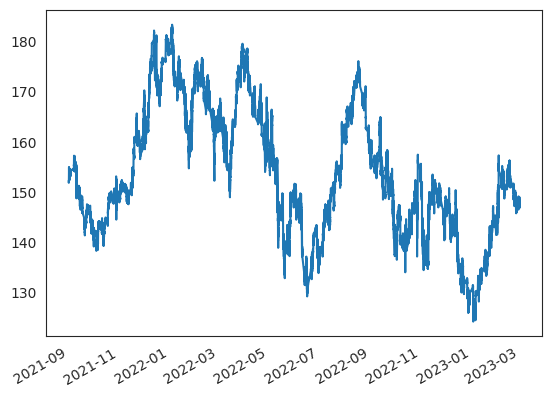

In [3]:
# loading csv with indicators unscaled

hdr = pd.read_csv(params.indunsc_csv, nrows=0).columns.tolist()
index_name = hdr[0]   # first column header, whatever it is

cols_needed = [
    "open","high","low","close","volume","trade_count","vwap","ask","bid",
    params.col_atr_tick, params.col_adx_tick, params.col_rsi_tick, params.col_vwap_tick,
]

usecols = [index_name] + cols_needed

df_inds = pd.read_csv(params.indunsc_csv, usecols=usecols, index_col=index_name, parse_dates=True)
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################
df_inds.close.plot()
df_inds

In [4]:
# # ##### 1.73e12 ######
# {'min_prof_thr': (0.00162, 0.00162),
#  'max_down_prop': (0.00448, 0.00448),
#  'gain_tightfact': (0.02824, 0.02824),
#  'tau_time': (5.50162, 5.50162),
#  'tau_dur': (6.45505, 6.45505),
#  'thresh_choice': {'categorical': ['median_nonzero']},
#  'reset_peak': (0, 0),
#  'rsi_min_thresh': (2, 2),
#  'rsi_max_thresh': (83, 83),
#  'adx_thresh': (8.04501, 8.04501),
#  'atr_mult': (0.09344, 0.09344),
#  'vwap_atr_mult': (2.79554, 2.79554),
#  'buy_factor': (0.00698, 0.00698),
#  'sell_factor': (0.0062, 0.0062),
#  'trailstop_pct': (0.00295, 0.00295)}

# # ##### 1.7e12 ######
# {'min_prof_thr': (1.602393636068798e-05, 0.003023976063639312),
#  'max_down_prop': (0.0038248057217431224, 0.005055194278256877),
#  'gain_tightfact': (0.03396321338777029, 0.04361678661222971),
#  'tau_time': (5.499786849218062, 5.503083150781937),
#  'tau_dur': (6.353872465551873, 6.513467534448126),
#  'thresh_choice': {'categorical': ['median_nonzero']},
#  'reset_peak': (0, 0),
#  'rsi_min_thresh': (1, 3),
#  'rsi_max_thresh': (76, 92),
#  'adx_thresh': (7.7874912718650195, 8.392478728134982),
#  'atr_mult': (0.0896175234154521, 0.0977424765845479),
#  'vwap_atr_mult': (-4.914678141392759, 0.08226814139275929),
#  'buy_factor': (0.005559091782229434, 0.007650908217770565),
#  'sell_factor': (0.005189692373869816, 0.006620307626130185),
#  'trailstop_pct': (-6.641867784973903, 11.102117784973903)}

In [5]:
prun_perc       = 80
report_interval = 50

col_signal = "targ_signal"

def objective(trial: optuna.Trial) -> float:
    min_prof_thr    = trial.suggest_float("min_prof_thr", 0.001, 0.002)
    max_down_prop   = trial.suggest_float("max_down_prop", 0.003, 0.005)
    gain_tightfact  = trial.suggest_float("gain_tightfact", 0.025, 0.035)
    tau_time        = trial.suggest_float("tau_time", 5.4, 5.6)
    tau_dur         = trial.suggest_float("tau_dur", 6.3, 6.55)
    
    thresh_choice = trial.suggest_categorical("thresh_choice",
        ["median_nonzero"])

    if thresh_choice == "numeric":
        thresh_mode = trial.suggest_float("thresh_value", 0.01, 1.0)
        thresh_window = None
    else: # signal threshold
        thresh_mode = thresh_choice
        thresh_window = trial.suggest_int("thresh_window", 5, 200) if thresh_choice.startswith("roll") else None

    reset_peak     = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 1, 3)
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 80), 87)
    adx_thresh     = trial.suggest_float("adx_thresh", 7.8, 8.2)
    atr_mult       = trial.suggest_float("atr_mult", 0.08, 0.1)
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -5, 5)
    buy_factor     = trial.suggest_float("buy_factor", 0.006, 0.008)
    sell_factor    = trial.suggest_float("sell_factor", 0.005, 0.007)
    trailstop_pct  = trial.suggest_float("trailstop_pct", 0, 10)

    print("-" * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    # 1) detect swings / build raw signal columns (no thresholding)
    df_build = preps.build_signal_per_day(
        df              = df_inds.copy(),
        min_prof_thr    = min_prof_thr,
        max_down_prop   = max_down_prop,
        gain_tightfact  = gain_tightfact,
        tau_time        = tau_time,
        tau_dur         = tau_dur,
        col_close       = "close",
    )

    # 2) compute per-day thresholds and gap_to_thresh
    df_thresh = preps.apply_thresholds_per_day(
        df              = df_build,
        thresh_mode     = thresh_mode,
        thresh_window   = thresh_window,
        col_signal      = col_signal
    )

    # Reset globals
    start_ask = df_thresh.loc[df_thresh.index.normalize() == df_thresh.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)

    # Group per-day for this trial
    groups = list(df_thresh.groupby(df_thresh.index.normalize()))

    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    
    acc = opts.TrialAccumulator(trial, pbar, report_interval=report_interval, prun_perc=prun_perc)
    
    for step, (day, df_day) in enumerate(pbar, 1):
        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = col_signal,
            sign_thresh     = "signal_thresh",
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day         = day,
            df          = df_actions,
            buy_factor  = buy_factor,
            sell_factor = sell_factor,
        )

        # process results and possibly prune
        acc.process(sim_results, step, parse_eq_value_callable=strats._parse_eq_value)

        # cleanup
        del df_actions, sim_results
        df_day = df_actions = sim_results = None

    # finalize and return objective
    return acc.finalize()


Baseline mean daily B&H: -9.5162


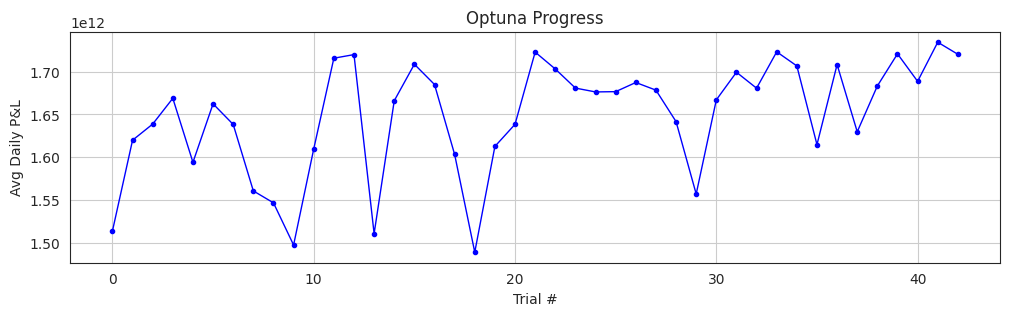

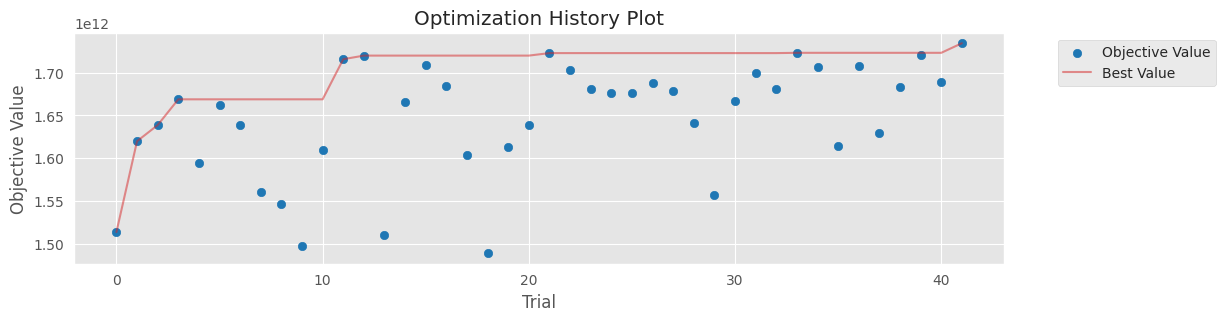

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018241589207379665; max_down_prop=0.004497942193062648; gain_tightfact=0.026528454942318185; tau_time=5.5164857586096145; tau_dur=6.514482260403914; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=84; adx_thresh=7.936967513717227; atr_mult=0.09930526166408597; vwap_atr_mult=-1.0122078554090432; buy_factor=0.0073827502415273775; sell_factor=0.00509766507291064; trailstop_pct=9.761013853947437


Trial 0: 100%|██████████| 375/375 [00:54<00:00,  6.91it/s]


[Results] mean_pnl:1514166629932.9529 mean_bh:-8.7491 mean_excess:1514166629941.7024 improv_vs_bh:17306560048698.07%
Action counts: {'Buy': 44782, 'Sell': 39212, 'Hold': 266717}
Best trial is: 0 with best_val: 1514166629941.7024
[save_results] wrote optuna_results/AAPL_1514166629941.7024_target.csv
[save_best_json] wrote optuna_results/AAPL_1514166629941.7024_target.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018916787976514262; max_down_prop=0.003250425875486484; gain_tightfact=0.030466461605439598; tau_time=5.457222509556512; tau_dur=6.396710384175155; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; adx_thresh=8.023840108277136; atr_mult=0.08270231073278639; vwap_atr_mult=1.4591510818209183; buy_factor=0.007359406854310131; sell_factor=0.0063184272256266915; trailstop_pct=9.951118666622026


Trial 1: 100%|██████████| 375/375 [00:38<00:00,  9.77it/s]


[Results] mean_pnl:1619994952420.3401 mean_bh:-8.7491 mean_excess:1619994952429.0894 improv_vs_bh:18516152296845.47%
Action counts: {'Buy': 44810, 'Sell': 39256, 'Hold': 266645}
Best trial is: 1 with best_val: 1619994952429.0894
[save_results] wrote optuna_results/AAPL_1619994952429.0894_target.csv
[save_best_json] wrote optuna_results/AAPL_1619994952429.0894_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001906395879962557; max_down_prop=0.004050809979002632; gain_tightfact=0.027098055928927688; tau_time=5.452149218358169; tau_dur=6.4537424528243195; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=8.034584295705384; atr_mult=0.08128934972110968; vwap_atr_mult=0.998012773818453; buy_factor=0.007734509829065446; sell_factor=0.0062123183024985346; trailstop_pct=4.540918968829009


Trial 2: 100%|██████████| 375/375 [00:40<00:00,  9.19it/s]


[Results] mean_pnl:1638788368765.5125 mean_bh:-8.7491 mean_excess:1638788368774.2610 improv_vs_bh:18730956521206.45%
Action counts: {'Buy': 44815, 'Sell': 39288, 'Hold': 266608}
Best trial is: 2 with best_val: 1638788368774.2610
[save_results] wrote optuna_results/AAPL_1638788368774.261_target.csv
[save_best_json] wrote optuna_results/AAPL_1638788368774.261_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013579384272880831; max_down_prop=0.0035272139544904315; gain_tightfact=0.03259725529159793; tau_time=5.415600884577421; tau_dur=6.394226952125457; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=82; adx_thresh=8.068206712639753; atr_mult=0.08496943943013292; vwap_atr_mult=-1.6012530997384298; buy_factor=0.007182073502144717; sell_factor=0.0069164070694762835; trailstop_pct=2.5404232975664387


Trial 3: 100%|██████████| 375/375 [00:51<00:00,  7.25it/s]


[Results] mean_pnl:1668798329542.9370 mean_bh:-8.7491 mean_excess:1668798329551.6863 improv_vs_bh:19073963148075.23%
Action counts: {'Buy': 44992, 'Sell': 39257, 'Hold': 266462}
Best trial is: 3 with best_val: 1668798329551.6863
[save_results] wrote optuna_results/AAPL_1668798329551.6863_target.csv
[save_best_json] wrote optuna_results/AAPL_1668798329551.6863_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00156237233518558; max_down_prop=0.003981294864584056; gain_tightfact=0.025814812770009028; tau_time=5.47087979056372; tau_dur=6.342356162040899; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=82; adx_thresh=7.885826737273628; atr_mult=0.08090092236153684; vwap_atr_mult=2.125166387231962; buy_factor=0.007659289973154197; sell_factor=0.005036003428133701; trailstop_pct=5.006487567864834


Trial 4: 100%|██████████| 375/375 [00:53<00:00,  6.99it/s]


[Results] mean_pnl:1594240748804.7019 mean_bh:-8.7491 mean_excess:1594240748813.4514 improv_vs_bh:18221787949773.84%
Action counts: {'Buy': 44724, 'Sell': 39230, 'Hold': 266757}
Best trial is: 3 with best_val: 1668798329551.6863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00132490706484863; max_down_prop=0.003625204511399203; gain_tightfact=0.031878798760366346; tau_time=5.446097663945262; tau_dur=6.345657874196327; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.031512977627333; atr_mult=0.08058055646019147; vwap_atr_mult=0.9212866279281435; buy_factor=0.007773457493103746; sell_factor=0.005935433141798004; trailstop_pct=0.9075574496687944


Trial 5: 100%|██████████| 375/375 [00:51<00:00,  7.28it/s]


[Results] mean_pnl:1662372918106.2419 mean_bh:-8.7491 mean_excess:1662372918114.9907 improv_vs_bh:19000522242254.30%
Action counts: {'Buy': 44909, 'Sell': 39314, 'Hold': 266488}
Best trial is: 3 with best_val: 1668798329551.6863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013428852666755497; max_down_prop=0.004441382587329909; gain_tightfact=0.028696693231290947; tau_time=5.4683522530045545; tau_dur=6.3115216038341115; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.019180122190956; atr_mult=0.08673592170883876; vwap_atr_mult=-3.4474539196449894; buy_factor=0.0077894638447661155; sell_factor=0.006574017280946174; trailstop_pct=1.4953583696496375


Trial 6: 100%|██████████| 375/375 [00:56<00:00,  6.59it/s]


[Results] mean_pnl:1638363225953.1531 mean_bh:-8.7491 mean_excess:1638363225961.9021 improv_vs_bh:18726097241213.18%
Action counts: {'Buy': 45036, 'Sell': 39344, 'Hold': 266331}
Best trial is: 3 with best_val: 1668798329551.6863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0018465291681325072; max_down_prop=0.0037706890900234442; gain_tightfact=0.033789615595430214; tau_time=5.5307187781846645; tau_dur=6.421647703252608; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=84; adx_thresh=7.944430425413315; atr_mult=0.08373766103276084; vwap_atr_mult=-4.619306291457321; buy_factor=0.006485853988675605; sell_factor=0.006186372955692022; trailstop_pct=6.71859896794402


Trial 7: 100%|██████████| 375/375 [01:08<00:00,  5.47it/s]


[Results] mean_pnl:1560917776912.0632 mean_bh:-8.7491 mean_excess:1560917776920.8127 improv_vs_bh:17840914403456.66%
Action counts: {'Buy': 44914, 'Sell': 39292, 'Hold': 266505}
Best trial is: 3 with best_val: 1668798329551.6863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016327167416878671; max_down_prop=0.004326939170973779; gain_tightfact=0.02906898947588208; tau_time=5.513389329909775; tau_dur=6.3363489500123755; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; adx_thresh=8.196179850195486; atr_mult=0.08993174842491321; vwap_atr_mult=-0.3231070177140367; buy_factor=0.006884500536580689; sell_factor=0.005169699742256098; trailstop_pct=3.216192671003272


Trial 8: 100%|██████████| 375/375 [00:55<00:00,  6.72it/s]


[Results] mean_pnl:1547030225856.4282 mean_bh:-8.7491 mean_excess:1547030225865.1770 improv_vs_bh:17682183038281.25%
Action counts: {'Buy': 44811, 'Sell': 39254, 'Hold': 266646}
Best trial is: 3 with best_val: 1668798329551.6863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013044101604617862; max_down_prop=0.0031864207296717585; gain_tightfact=0.031184875874203665; tau_time=5.542015871842787; tau_dur=6.450984322157565; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=86; adx_thresh=7.925420734434397; atr_mult=0.09972834267839528; vwap_atr_mult=-0.6245778319594386; buy_factor=0.006527348900099546; sell_factor=0.005115655563054051; trailstop_pct=9.333569914805981


Trial 9: 100%|██████████| 375/375 [00:50<00:00,  7.41it/s]


[Results] mean_pnl:1497899750295.5254 mean_bh:-8.7491 mean_excess:1497899750304.2744 improv_vs_bh:17120633530649.71%
Action counts: {'Buy': 44831, 'Sell': 39250, 'Hold': 266630}
Best trial is: 3 with best_val: 1668798329551.6863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010108356923037313; max_down_prop=0.004924138474315082; gain_tightfact=0.03491774800265632; tau_time=5.402796144717156; tau_dur=6.548626206365139; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=80; adx_thresh=8.123182154471337; atr_mult=0.09512107653799998; vwap_atr_mult=3.911823520232438; buy_factor=0.00605575378257891; sell_factor=0.00699369594417434; trailstop_pct=2.3923337217012377


Trial 10: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:1609767111912.6614 mean_bh:-8.7491 mean_excess:1609767111921.4104 improv_vs_bh:18399250542167.74%
Action counts: {'Buy': 44583, 'Sell': 39137, 'Hold': 266991}
Best trial is: 3 with best_val: 1668798329551.6863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012571718987078905; max_down_prop=0.0035489104830233663; gain_tightfact=0.03278232389471234; tau_time=5.402487844441857; tau_dur=6.3726810683312385; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.112750793088614; atr_mult=0.08640538308487264; vwap_atr_mult=-2.4702453082495928; buy_factor=0.007983608332042733; sell_factor=0.005745770494717708; trailstop_pct=0.24147522547983913


Trial 11: 100%|██████████| 375/375 [00:34<00:00, 10.86it/s]


[Results] mean_pnl:1715530540070.9060 mean_bh:-8.7491 mean_excess:1715530540079.6550 improv_vs_bh:19608101063756.18%
Action counts: {'Buy': 45069, 'Sell': 39327, 'Hold': 266315}
Best trial is: 11 with best_val: 1715530540079.6550
[save_results] wrote optuna_results/AAPL_1715530540079.655_target.csv
[save_best_json] wrote optuna_results/AAPL_1715530540079.655_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010959107683345057; max_down_prop=0.003470128114513509; gain_tightfact=0.03280649505421111; tau_time=5.402146374080245; tau_dur=6.381870326636238; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.098348787539551; atr_mult=0.08714279256842704; vwap_atr_mult=-2.2944221694342906; buy_factor=0.007131320199037371; sell_factor=0.005677891170784448; trailstop_pct=0.050459164938650214


Trial 12: 100%|██████████| 375/375 [00:41<00:00,  9.07it/s]


[Results] mean_pnl:1719724714231.9399 mean_bh:-8.7491 mean_excess:1719724714240.6890 improv_vs_bh:19656039464680.67%
Action counts: {'Buy': 45098, 'Sell': 39323, 'Hold': 266290}
Best trial is: 12 with best_val: 1719724714240.6890
[save_results] wrote optuna_results/AAPL_1719724714240.689_target.csv
[save_best_json] wrote optuna_results/AAPL_1719724714240.689_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001058940409480364; max_down_prop=0.0030180870050132806; gain_tightfact=0.03322676991052596; tau_time=5.598664077627503; tau_dur=6.377361132392004; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.129780037807645; atr_mult=0.08783098839951838; vwap_atr_mult=-2.8141485580222034; buy_factor=0.006754654992072934; sell_factor=0.005655045631288269; trailstop_pct=0.030680063842158163


Trial 13: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:1511123584266.8452 mean_bh:-8.7491 mean_excess:1511123584275.5942 improv_vs_bh:17271778769339.51%
Action counts: {'Buy': 45021, 'Sell': 39267, 'Hold': 266423}
Best trial is: 12 with best_val: 1719724714240.6890
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011694150509478827; max_down_prop=0.0033904957577730265; gain_tightfact=0.034804542666051166; tau_time=5.424459900970436; tau_dur=6.37107230689839; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.816981279473345; atr_mult=0.09270175369026068; vwap_atr_mult=-2.4481826492983054; buy_factor=0.007984466416271424; sell_factor=0.005613720206229355; trailstop_pct=0.1111775158264195


Trial 14: 100%|██████████| 375/375 [00:52<00:00,  7.12it/s]


[Results] mean_pnl:1665968653776.2808 mean_bh:-8.7491 mean_excess:1665968653785.0293 improv_vs_bh:19041620635299.17%
Action counts: {'Buy': 45071, 'Sell': 39321, 'Hold': 266319}
Best trial is: 12 with best_val: 1719724714240.6890
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011766397018610352; max_down_prop=0.0037408948838134008; gain_tightfact=0.03201684295813919; tau_time=5.400904356638289; tau_dur=6.433494244205225; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.106403991841368; atr_mult=0.09047810106120178; vwap_atr_mult=-4.987073765342696; buy_factor=0.006114577574173923; sell_factor=0.005533027397768487; trailstop_pct=3.8417527889438086


Trial 15: 100%|██████████| 375/375 [00:39<00:00,  9.45it/s]


[Results] mean_pnl:1708505251359.8906 mean_bh:-8.7491 mean_excess:1708505251368.6399 improv_vs_bh:19527803705108.60%
Action counts: {'Buy': 45109, 'Sell': 39334, 'Hold': 266268}
Best trial is: 12 with best_val: 1719724714240.6890
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011829665327642881; max_down_prop=0.0039154649077649045; gain_tightfact=0.029957529428352524; tau_time=5.434394038777841; tau_dur=6.301041000457622; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.18666363752019; atr_mult=0.08615210718457975; vwap_atr_mult=-3.7532288419621787; buy_factor=0.007153716423033935; sell_factor=0.005851573033725413; trailstop_pct=6.145919553503211


Trial 16: 100%|██████████| 375/375 [00:36<00:00, 10.22it/s]


[Results] mean_pnl:1684893549218.5574 mean_bh:-8.7491 mean_excess:1684893549227.3064 improv_vs_bh:19257927634086.82%
Action counts: {'Buy': 45027, 'Sell': 39301, 'Hold': 266383}
Best trial is: 12 with best_val: 1719724714240.6890
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014763849157350894; max_down_prop=0.0034324696703146645; gain_tightfact=0.03355038815447259; tau_time=5.488554925383025; tau_dur=6.491921376863372; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.090180451978595; atr_mult=0.08915490220722504; vwap_atr_mult=-2.0028925940620232; buy_factor=0.007487456479022531; sell_factor=0.005370493761879439; trailstop_pct=1.4003306722540674


Trial 17: 100%|██████████| 375/375 [00:58<00:00,  6.44it/s]


[Results] mean_pnl:1603422712450.0039 mean_bh:-8.7491 mean_excess:1603422712458.7529 improv_vs_bh:18326735583706.64%
Action counts: {'Buy': 44949, 'Sell': 39301, 'Hold': 266461}
Best trial is: 12 with best_val: 1719724714240.6890
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001104822097285119; max_down_prop=0.004178014853301367; gain_tightfact=0.030672393853912443; tau_time=5.568659667784042; tau_dur=6.40440648174207; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=87; adx_thresh=8.14981964374026; atr_mult=0.0928805724786918; vwap_atr_mult=-3.4230244724827967; buy_factor=0.007985132771357943; sell_factor=0.0058131905457603815; trailstop_pct=7.840191171940011


Trial 18: 100%|██████████| 375/375 [00:55<00:00,  6.81it/s]


[Results] mean_pnl:1489494305535.4619 mean_bh:-8.7491 mean_excess:1489494305544.2107 improv_vs_bh:17024561320630.36%
Action counts: {'Buy': 44942, 'Sell': 39258, 'Hold': 266511}
Best trial is: 12 with best_val: 1719724714240.6890
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001206449045255077; max_down_prop=0.003198017271932328; gain_tightfact=0.032766755684590296; tau_time=5.49030281219154; tau_dur=6.368897430790824; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.979535517191413; atr_mult=0.08491417400879456; vwap_atr_mult=4.684797450479767; buy_factor=0.006652671260454798; sell_factor=0.005382097910849163; trailstop_pct=2.038448661372998


Trial 19: 100%|██████████| 375/375 [00:49<00:00,  7.59it/s]


[Results] mean_pnl:1612731046283.8723 mean_bh:-8.7491 mean_excess:1612731046292.6213 improv_vs_bh:18433127598471.47%
Action counts: {'Buy': 44816, 'Sell': 39321, 'Hold': 266574}
Best trial is: 12 with best_val: 1719724714240.6890
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001462312123936021; max_down_prop=0.003703986981052155; gain_tightfact=0.03415801264542475; tau_time=5.430431520960712; tau_dur=6.322174746521605; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=86; adx_thresh=8.066102612690347; atr_mult=0.09239011138965117; vwap_atr_mult=-1.3386215283320593; buy_factor=0.006274477852585698; sell_factor=0.0060185675936432455; trailstop_pct=0.7516194004564997


Trial 20: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:1638527276783.7986 mean_bh:-8.7491 mean_excess:1638527276792.5476 improv_vs_bh:18727972302712.66%
Action counts: {'Buy': 45006, 'Sell': 39264, 'Hold': 266441}
Best trial is: 12 with best_val: 1719724714240.6890
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011287484435053851; max_down_prop=0.003811747930438684; gain_tightfact=0.03196814710443992; tau_time=5.400064811495214; tau_dur=6.439080429950043; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.099324895837725; atr_mult=0.08809272929011241; vwap_atr_mult=-4.304389721683913; buy_factor=0.006039878781002844; sell_factor=0.0056033434969417276; trailstop_pct=3.683017043953397


Trial 21: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:1722640822558.0310 mean_bh:-8.7491 mean_excess:1722640822566.7800 improv_vs_bh:19689369880802.67%
Action counts: {'Buy': 45093, 'Sell': 39325, 'Hold': 266293}
Best trial is: 21 with best_val: 1722640822566.7800
[save_results] wrote optuna_results/AAPL_1722640822566.78_target.csv
[save_best_json] wrote optuna_results/AAPL_1722640822566.78_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001259158704360965; max_down_prop=0.003492051573384092; gain_tightfact=0.03159542625405303; tau_time=5.410084426888727; tau_dur=6.470986579558247; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.156710484371565; atr_mult=0.08776277125542786; vwap_atr_mult=-2.5953893562415886; buy_factor=0.007037497646411309; sell_factor=0.00540801322828522; trailstop_pct=3.4959751274046473


Trial 22: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:1702956775204.8174 mean_bh:-8.7491 mean_excess:1702956775213.5667 improv_vs_bh:19464385958436.79%
Action counts: {'Buy': 45080, 'Sell': 39297, 'Hold': 266334}
Best trial is: 21 with best_val: 1722640822566.7800
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011000540950991183; max_down_prop=0.0038283284141765895; gain_tightfact=0.032714628002536085; tau_time=5.4322350846847; tau_dur=6.4135560928417; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.073865956070541; atr_mult=0.08874938189061858; vwap_atr_mult=-4.029417904378635; buy_factor=0.006287656014287178; sell_factor=0.005720796616146204; trailstop_pct=5.279887297253451


Trial 23: 100%|██████████| 375/375 [00:34<00:00, 10.88it/s]


[Results] mean_pnl:1680719509173.2402 mean_bh:-8.7491 mean_excess:1680719509181.9890 improv_vs_bh:19210219361257.73%
Action counts: {'Buy': 45068, 'Sell': 39296, 'Hold': 266347}
Best trial is: 21 with best_val: 1722640822566.7800
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010366478765448488; max_down_prop=0.0033591278790933536; gain_tightfact=0.02957072107218158; tau_time=5.417506417514144; tau_dur=6.441812027076418; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.153536470724575; atr_mult=0.09114513457031041; vwap_atr_mult=-4.162394901574012; buy_factor=0.006887827596357856; sell_factor=0.006057978876921022; trailstop_pct=0.8798738306167221


Trial 24: 100%|██████████| 375/375 [00:39<00:00,  9.45it/s]


[Results] mean_pnl:1676228783774.8030 mean_bh:-8.7491 mean_excess:1676228783783.5520 improv_vs_bh:19158891451083.63%
Action counts: {'Buy': 45057, 'Sell': 39305, 'Hold': 266349}
Best trial is: 21 with best_val: 1722640822566.7800
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001386648547094097; max_down_prop=0.003607828139606443; gain_tightfact=0.0321262861585018; tau_time=5.43796153815453; tau_dur=6.356240071142136; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.108291434799291; atr_mult=0.08629375684925754; vwap_atr_mult=-3.040937947985567; buy_factor=0.007243816039924836; sell_factor=0.005495178890886923; trailstop_pct=2.71346537111266


Trial 25: 100%|██████████| 375/375 [00:35<00:00, 10.56it/s]


[Results] mean_pnl:1676575954368.2910 mean_bh:-8.7491 mean_excess:1676575954377.0400 improv_vs_bh:19162859527386.82%
Action counts: {'Buy': 45054, 'Sell': 39301, 'Hold': 266356}
Best trial is: 21 with best_val: 1722640822566.7800
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012222425907809512; max_down_prop=0.004167763130441097; gain_tightfact=0.03398107974671507; tau_time=5.401290554116657; tau_dur=6.387264946269636; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=7.98440427588622; atr_mult=0.09525366254327391; vwap_atr_mult=-1.9657980462749371; buy_factor=0.007502999169142323; sell_factor=0.005289100859222576; trailstop_pct=1.7320554828811683


Trial 26: 100%|██████████| 375/375 [00:53<00:00,  7.02it/s]


[Results] mean_pnl:1687232716047.4827 mean_bh:-8.7491 mean_excess:1687232716056.2319 improv_vs_bh:19284663747793.32%
Action counts: {'Buy': 45079, 'Sell': 39315, 'Hold': 266317}
Best trial is: 21 with best_val: 1722640822566.7800
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0011228830765527744; max_down_prop=0.003595371372929755; gain_tightfact=0.03120937392665261; tau_time=5.4176416554965785; tau_dur=6.474471628087584; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=87; adx_thresh=8.053446277813672; atr_mult=0.0839817586940257; vwap_atr_mult=-0.03286555650674454; buy_factor=0.006298194896710499; sell_factor=0.005707875704912657; trailstop_pct=4.162529509070976


Trial 27: 100%|██████████| 375/375 [00:49<00:00,  7.53it/s]


[Results] mean_pnl:1678332452744.3523 mean_bh:-8.7491 mean_excess:1678332452753.1021 improv_vs_bh:19182935880952.95%
Action counts: {'Buy': 45013, 'Sell': 39252, 'Hold': 266446}
Best trial is: 21 with best_val: 1722640822566.7800
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010003745923346605; max_down_prop=0.0030386939354927; gain_tightfact=0.033017192435804144; tau_time=5.459199327460496; tau_dur=6.418334657218396; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.095338401047936; atr_mult=0.08796691657481383; vwap_atr_mult=-4.147869946629578; buy_factor=0.006496316790918683; sell_factor=0.006491211680773839; trailstop_pct=8.124934474064132


Trial 28: 100%|██████████| 375/375 [00:57<00:00,  6.51it/s]


[Results] mean_pnl:1641646615933.3574 mean_bh:-8.7491 mean_excess:1641646615942.1067 improv_vs_bh:18763625598219.62%
Action counts: {'Buy': 44984, 'Sell': 39319, 'Hold': 266408}
Best trial is: 21 with best_val: 1722640822566.7800
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0019953919990369764; max_down_prop=0.003903858088001964; gain_tightfact=0.028156496439200793; tau_time=5.47363157438986; tau_dur=6.495185356746962; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=84; adx_thresh=8.162777715650943; atr_mult=0.09615183231526; vwap_atr_mult=-1.0572132440087207; buy_factor=0.007002324343287399; sell_factor=0.00581596014072209; trailstop_pct=0.43507424053638233


Trial 29: 100%|██████████| 375/375 [00:41<00:00,  9.00it/s]


[Results] mean_pnl:1557318459735.5334 mean_bh:-8.7491 mean_excess:1557318459744.2822 improv_vs_bh:17799775074654.84%
Action counts: {'Buy': 44841, 'Sell': 39221, 'Hold': 266649}
Best trial is: 21 with best_val: 1722640822566.7800
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016529920728571555; max_down_prop=0.004876050128995268; gain_tightfact=0.030969689265346104; tau_time=5.441766402865988; tau_dur=6.52735852119062; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.121793532898083; atr_mult=0.08221021467264189; vwap_atr_mult=-2.5026702890117587; buy_factor=0.007610560197490106; sell_factor=0.00523628529215761; trailstop_pct=5.837262296691961


Trial 30: 100%|██████████| 375/375 [00:37<00:00,  9.98it/s]


[Results] mean_pnl:1667012958922.7046 mean_bh:-8.7491 mean_excess:1667012958931.4541 improv_vs_bh:19053556791709.14%
Action counts: {'Buy': 44986, 'Sell': 39326, 'Hold': 266399}
Best trial is: 21 with best_val: 1722640822566.7800
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001137394462167379; max_down_prop=0.0037706918087666626; gain_tightfact=0.03216364750000687; tau_time=5.403568923795439; tau_dur=6.438661854923077; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.091876335187516; atr_mult=0.09113219154011415; vwap_atr_mult=-4.876907513186754; buy_factor=0.0060778409138832245; sell_factor=0.005529480211127438; trailstop_pct=3.7625664590315586


Trial 31: 100%|██████████| 375/375 [00:51<00:00,  7.29it/s]


[Results] mean_pnl:1699185694796.6514 mean_bh:-8.7491 mean_excess:1699185694805.4006 improv_vs_bh:19421283417248.90%
Action counts: {'Buy': 45107, 'Sell': 39327, 'Hold': 266277}
Best trial is: 21 with best_val: 1722640822566.7800
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012658472249043279; max_down_prop=0.003293462830139056; gain_tightfact=0.03178599425905502; tau_time=5.422899148572281; tau_dur=6.431124399673019; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.132279737741884; atr_mult=0.09041200913802848; vwap_atr_mult=-4.963223337921218; buy_factor=0.006144617792780502; sell_factor=0.005486493740118815; trailstop_pct=2.898973384932857


Trial 32: 100%|██████████| 375/375 [00:56<00:00,  6.68it/s]


[Results] mean_pnl:1680591263455.3567 mean_bh:-8.7491 mean_excess:1680591263464.1057 improv_vs_bh:19208753543577.13%
Action counts: {'Buy': 45065, 'Sell': 39317, 'Hold': 266329}
Best trial is: 21 with best_val: 1722640822566.7800
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014217915486940983; max_down_prop=0.003707596007326338; gain_tightfact=0.030142691241826558; tau_time=5.400580479001985; tau_dur=6.403779777497725; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.045807157825811; atr_mult=0.08689683578391329; vwap_atr_mult=-4.357085639341151; buy_factor=0.007376678886799266; sell_factor=0.005582921424570738; trailstop_pct=4.658825689243037


Trial 33: 100%|██████████| 375/375 [01:22<00:00,  4.52it/s]


[Results] mean_pnl:1722969868943.8606 mean_bh:-8.7491 mean_excess:1722969868952.6094 improv_vs_bh:19693130801775.67%
Action counts: {'Buy': 45111, 'Sell': 39323, 'Hold': 266277}
Best trial is: 33 with best_val: 1722969868952.6094
[save_results] wrote optuna_results/AAPL_1722969868952.6094_target.csv
[save_best_json] wrote optuna_results/AAPL_1722969868952.6094_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013916973896808378; max_down_prop=0.0035327141439371827; gain_tightfact=0.02755960090189912; tau_time=5.41400814965789; tau_dur=6.397451607090818; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.04670854877514; atr_mult=0.08523320727419018; vwap_atr_mult=-3.198716070053675; buy_factor=0.007345756053475143; sell_factor=0.0056334341159901494; trailstop_pct=4.438751947939125


Trial 34: 100%|██████████| 375/375 [00:57<00:00,  6.52it/s]


[Results] mean_pnl:1706528560371.2996 mean_bh:-8.7491 mean_excess:1706528560380.0491 improv_vs_bh:19505210602992.03%
Action counts: {'Buy': 45104, 'Sell': 39317, 'Hold': 266290}
Best trial is: 33 with best_val: 1722969868952.6094
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001563313095287117; max_down_prop=0.0040836801205526305; gain_tightfact=0.03025513716411824; tau_time=5.455119260908032; tau_dur=6.359667531944975; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=82; adx_thresh=7.993998229891886; atr_mult=0.08718520173586627; vwap_atr_mult=-2.0069717133312612; buy_factor=0.007327559362020308; sell_factor=0.005937113958193346; trailstop_pct=7.015395856290429


Trial 35: 100%|██████████| 375/375 [00:55<00:00,  6.82it/s]


[Results] mean_pnl:1614843295989.8799 mean_bh:-8.7491 mean_excess:1614843295998.6294 improv_vs_bh:18457270104092.71%
Action counts: {'Buy': 44922, 'Sell': 39288, 'Hold': 266501}
Best trial is: 33 with best_val: 1722969868952.6094
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0014271036493461713; max_down_prop=0.003635655792554487; gain_tightfact=0.02509927769439475; tau_time=5.414207024070116; tau_dur=6.381945102972958; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.020410254290463; atr_mult=0.08277770938612349; vwap_atr_mult=0.8706515462596148; buy_factor=0.007108846198403685; sell_factor=0.006150950902366292; trailstop_pct=5.471533227035071


Trial 36: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:1708146504646.5977 mean_bh:-8.7491 mean_excess:1708146504655.3464 improv_vs_bh:19523703316542.96%
Action counts: {'Buy': 45055, 'Sell': 39299, 'Hold': 266357}
Best trial is: 33 with best_val: 1722969868952.6094
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0012652951837517743; max_down_prop=0.00389255658813934; gain_tightfact=0.029700376071630695; tau_time=5.44709937399443; tau_dur=6.4067060617710565; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; adx_thresh=8.072991930510936; atr_mult=0.08555437947832602; vwap_atr_mult=-4.210231309363289; buy_factor=0.007505875012387398; sell_factor=0.005754243078509425; trailstop_pct=1.3168140629595932


Trial 37: 100%|██████████| 375/375 [00:33<00:00, 11.27it/s]


[Results] mean_pnl:1629815630398.4690 mean_bh:-8.7491 mean_excess:1629815630407.2183 improv_vs_bh:18628400281833.73%
Action counts: {'Buy': 44944, 'Sell': 39280, 'Hold': 266487}
Best trial is: 33 with best_val: 1722969868952.6094
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001067090075784173; max_down_prop=0.0040586065139854854; gain_tightfact=0.03332569326458978; tau_time=5.4254766771704; tau_dur=6.390851526060925; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.047913354376025; atr_mult=0.08886921432787977; vwap_atr_mult=2.11654719311533; buy_factor=0.00784713193320397; sell_factor=0.006293348033346728; trailstop_pct=4.847922015948899


Trial 38: 100%|██████████| 375/375 [00:37<00:00,  9.98it/s]


[Results] mean_pnl:1683215116677.8103 mean_bh:-8.7491 mean_excess:1683215116686.5596 improv_vs_bh:19238743554224.19%
Action counts: {'Buy': 44907, 'Sell': 39276, 'Hold': 266528}
Best trial is: 33 with best_val: 1722969868952.6094
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013262905259878765; max_down_prop=0.0034974601219809466; gain_tightfact=0.03240449645881441; tau_time=5.409677733663593; tau_dur=6.461797456300028; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.00462276320269; atr_mult=0.0839743644597586; vwap_atr_mult=-3.54790120990745; buy_factor=0.006808265815456931; sell_factor=0.005890347916369911; trailstop_pct=1.9799738272130711


Trial 39: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:1720622528038.6743 mean_bh:-8.7491 mean_excess:1720622528047.4231 improv_vs_bh:19666301260345.39%
Action counts: {'Buy': 45106, 'Sell': 39329, 'Hold': 266276}
Best trial is: 33 with best_val: 1722969868952.6094
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0015376183903359907; max_down_prop=0.004607378659104323; gain_tightfact=0.03045836550588638; tau_time=5.411767097211778; tau_dur=6.463404011661574; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=86; adx_thresh=7.933455719707741; atr_mult=0.08433890997951497; vwap_atr_mult=-3.6894617044542546; buy_factor=0.006875518338813674; sell_factor=0.005971106476130722; trailstop_pct=2.172554408326415


Trial 40: 100%|██████████| 375/375 [00:47<00:00,  7.86it/s]


[Results] mean_pnl:1688567356473.6641 mean_bh:-8.7491 mean_excess:1688567356482.4131 improv_vs_bh:19299918366553.49%
Action counts: {'Buy': 45092, 'Sell': 39283, 'Hold': 266336}
Best trial is: 33 with best_val: 1722969868952.6094
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.001309358769176495; max_down_prop=0.0034733963075952736; gain_tightfact=0.03242796767281893; tau_time=5.40094703064357; tau_dur=6.458220630594697; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.028310015845904; atr_mult=0.08317832109796953; vwap_atr_mult=-4.3528402130822075; buy_factor=0.007234366681227482; sell_factor=0.005869395583367364; trailstop_pct=0.6811456523645749


Trial 41: 100%|██████████| 375/375 [01:05<00:00,  5.75it/s]


[Results] mean_pnl:1734148328194.7783 mean_bh:-8.7491 mean_excess:1734148328203.5276 improv_vs_bh:19820897899829.72%
Action counts: {'Buy': 45107, 'Sell': 39330, 'Hold': 266274}
Best trial is: 41 with best_val: 1734148328203.5276
[save_results] wrote optuna_results/AAPL_1734148328203.5276_target.csv
[save_best_json] wrote optuna_results/AAPL_1734148328203.5276_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013211850304290253; max_down_prop=0.0034262327528739368; gain_tightfact=0.032426602390003806; tau_time=5.4108592248418494; tau_dur=6.457041939395394; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=7.955994827938213; atr_mult=0.08188250157590612; vwap_atr_mult=-4.5783467553226265; buy_factor=0.007291002255680013; sell_factor=0.00585967539355465; trailstop_pct=0.8552919415670854


Trial 42: 100%|██████████| 375/375 [00:57<00:00,  6.54it/s]


[Results] mean_pnl:1720083388449.0732 mean_bh:-8.7491 mean_excess:1720083388457.8223 improv_vs_bh:19660139024632.65%
Action counts: {'Buy': 45111, 'Sell': 39331, 'Hold': 266269}
Best trial is: 41 with best_val: 1734148328203.5276
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0013260106015005946; max_down_prop=0.0032917044344521903; gain_tightfact=0.031550883316929644; tau_time=5.421244841233059; tau_dur=6.453679854412508; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=7.960732253908384; atr_mult=0.08171792968941333; vwap_atr_mult=-4.551894390543521; buy_factor=0.007226715334624302; sell_factor=0.005901599076143643; trailstop_pct=3.011980785727528


Trial 43:  94%|█████████▍| 354/375 [00:46<00:02,  7.57it/s]


KeyboardInterrupt: 

In [6]:
importlib.reload(opts) ########
# Warmup steps computed once from base data
base_groups        = list(df_inds.groupby(df_inds.index.normalize()))
total_days_base    = len(base_groups)
reports_per_trial  = math.ceil(total_days_base / report_interval)
n_warmup_steps     = math.ceil(reports_per_trial * 0.30)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 5000
trials_before_pruning = 150
trials_of_exploration = 250

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(pruner=pruner, 
                            # sampler=sampler,
                            direction="maximize")

# Per-run callbacks with suffix "target"
cb_save_csv  = opts.make_save_results_callback("target")
cb_save_json = opts.make_save_best_json_callback("target")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()